In [1]:
using Pkg
Pkg.activate("..")
using Revise
using FUSE
using FUSE.IMAS

  Activating environment at `~/.julia/dev/FUSE/Project.toml`
┌ Info: Precompiling FUSE [e64856f0-3bb8-4376-b4b7-c03396503992]
└ @ Base loading.jl:1317


In [47]:
R0 = 1.8
δ = 0.5
ϵ = 0.3
κ = 1.9
B0 = 2.0
qstar = 1.57
beta_t = 0.2

eq0=FUSE.init(IMAS.equilibrium(), 0.0; B0, R0, ϵ, δ, κ, beta_t, qstar)
eq=FUSE.SolovevEquilibriumActor(eq0, 0.0);
FUSE.step(eq; abs_error=1E-4,verbose=false)
@time eq1=FUSE.finalize(eq,257);

# using PyPlot
# using Equilibrium


# eqt = eq1.time_slice[1]

# eqt.profiles_1d.elongation=zero(eqt.profiles_1d.psi)
# #eqt.profiles_1d.triangularity=zero(eqt.profiles_1d.psi)
# eqt.profiles_1d.triangularity_lower=zero(eqt.profiles_1d.psi)
# eqt.profiles_1d.triangularity_upper=zero(eqt.profiles_1d.psi)
# eqt.profiles_1d.r_inboard=zero(eqt.profiles_1d.psi)
# eqt.profiles_1d.r_outboard=zero(eqt.profiles_1d.psi)
# for (k,psi_level) in enumerate(eqt.profiles_1d.psi)
#     pr,pz=FUSE.flux_surface(eqt,psi_level)
#     tmp = FUSE.fluxGeo(pr,pz)
#     eqt.profiles_1d.elongation[k]=tmp["kappa"]
#     #eqt.profiles_1d.triangularity[k]=tmp["delta"]
#     eqt.profiles_1d.triangularity_upper[k]=tmp["delu"]
#     eqt.profiles_1d.triangularity_lower[k]=tmp["dell"]
#     eqt.profiles_1d.r_outboard[k] = tmp["max_r"]
#     eqt.profiles_1d.r_inboard[k] = tmp["min_r"]
#     eqt.boundary.elongation_upper=tmp["kapu"]
#     eqt.boundary.elongation_lower=tmp["kapl"]
#     try
#         PyPlot.plot(pr,pz,"b")
#     catch
#         println(k)
#     end
# end

# PyPlot.gca().set_aspect("equal")
#eq0
#PyPlot.figure()
#PyPlot.plot(eqt.profiles_1d.elongation,".-")

  0.272048 seconds (290.35 k allocations: 149.203 MiB, 3.96% gc time)


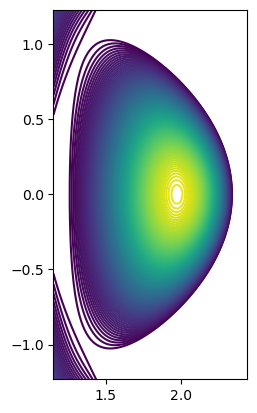

In [137]:
using Equilibrium
psi=Equilibrium.psi_limits(eq.S)
psi=collect(range(psi[1],psi[end],length=100))
psin=collect(range(0.0,1.0,length=length(psi)))
p=Equilibrium.pressure(eq.S,psi)
pprime=Equilibrium.pressure_gradient(eq.S,psi)
f=Equilibrium.poloidal_current(eq.S,psi)
fprime=Equilibrium.poloidal_current_gradient(eq.S,psi)
mu0 = 4*pi*1e-7

function Psi(M::AbstractEquilibrium, dx=0.01,dy=0.01)
    xlims, ylims = limits(M)
    x = range(xlims...,step=dx)
    y = range(ylims...,step=dy)
    return collect(x),collect(y),[M(xx,yy) for xx in x, yy in y]
end

levels=sort(range(Equilibrium.psi_limits(eq.S)...,length=110))

x,y,PSI=Psi(eq.S)
PyPlot.contour(x,y,transpose(PSI),tmp)
PyPlot.gca().set_aspect("equal")
#PyPlot.plot(psin,f.*fprime)

In [22]:
using Printf
digits = -Int(log10(1E-9))
txt = "α=%3.$(digits)f β_t=%3.$(digits)e precision=%3.$(digits)e\n"

@printf(txt, 1,2,3)

LoadError: LoadError: MethodError: no method matching Printf.Format(::Int64)
[0mClosest candidates are:
[0m  Printf.Format(::S, [91m::Vector{UnitRange{Int64}}[39m, [91m::T[39m) where {S, T} at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:64
[0m  Printf.Format([91m::AbstractString[39m) at /Users/julia/buildbot/worker/package_macos64/build/usr/share/julia/stdlib/v1.6/Printf/src/Printf.jl:80
in expression starting at In[22]:5